In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from timeit import default_timer as timer

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels

dtype = np.float32

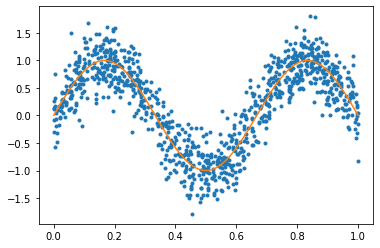

In [44]:
def true_fun(ind, noise_var):
    y_true = np.sin(3 * np.pi * ind)
    y_obs = y_true + np.random.normal(scale=np.sqrt(noise_var), size=y_true.shape).astype(dtype)
    return y_obs, y_true

n_train = 1000
obs_noise_var = 0.1

train_ind = np.random.uniform(0, 1, size=(n_train)).astype(dtype)
train_ind.sort()
y_obs, y_true = true_fun(train_ind, obs_noise_var)

plt.plot(train_ind, y_obs, '.')
plt.plot(train_ind, y_true)


In [36]:
def joint_gpr_model(x):
    if x.ndim == 1:
        x = x[:, np.newaxis]

    return tfd.JointDistributionNamed(dict(
        amp = tfd.LogNormal(loc=0, scale=1.),
        lenscale = tfd.LogNormal(loc=0., scale=1.),
        obs_var = tfd.LogNormal(loc=0., scale=1.),
        obs = lambda amp, lenscale, obs_var: tfd.GaussianProcess(
            kernel = tfk.ExponentiatedQuadratic(amplitude=amp, length_scale=lenscale),
            index_points = x,
            observation_noise_variance = obs_var
        )
    ))


In [59]:
constrain_positive = tfb.Shift(np.finfo(np.float32).tiny)(tfb.Exp())
amp = tfp.util.TransformedVariable(1., constrain_positive, name='amplitude')
lenscale = tfp.util.TransformedVariable(1., constrain_positive,name='length_scale')
obs_var = tfp.util.TransformedVariable(1., constrain_positive, name='obs_noise_var')

model = joint_gpr_model(train_ind)
optimizer = tf.optimizers.Adam(learning_rate=.01)

# @tf.function
def loss():
    log_prob = model.log_prob(dict(
        amp = amp,
        lenscale = lenscale,
        obs_var = obs_var,
        obs = y_obs
    ))
    return - log_prob / y_obs.siz
trainable = [t.trainable_variables[0] for t in (amp, lenscale, obs_var)]
e

def train_step():
    optimizer.moptimizer.minimize(loss, trainable)timer()
l = []
for i in range(1000):
    train_step()
    l.append(loss())
end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

plt.plot(l)
plt.title(f'Loss: {l[-1]: .3f}, amp: {tf.convert_to_tensor(amp).numpy(): .3f}, lenscale: {tf.convert_to_tensor(lenscale).numpy(): .3f}, obs_var: {tf.convert_to_tensor(obs_var).numpy(): .3f}');

SyntaxError: invalid syntax (<ipython-input-59-cfaf3124de2f>, line 22)